In [2]:
# 1. Imports iniciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import joblib
import kagglehub
import os

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 2. Carregar dados Kaggle
path = kagglehub.dataset_download("arnabchaki/data-science-salaries-2023")
df = pd.read_csv(os.path.join(path, "ds_salaries.csv"))

df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [4]:
# 3. Preparar variável-alvo (classificação por faixa salarial)

# Definir os limites das faixas salariais
bins = [0, 50000, 100000, 150000, 200000, 300000, float('inf')]

# Nomes amigáveis para cada faixa
labels = [
    "Até 50k",
    "50k–100k",
    "100k–150k",
    "150k–200k",
    "200k–300k",
    "Acima de 300k"
]

# Criar nova coluna com as faixas
df["faixa_salarial"] = pd.cut(df["salary_in_usd"], bins=bins, labels=labels, right=False)

# Visualizar distribuição
df["faixa_salarial"].value_counts().sort_index()

faixa_salarial
Até 50k           264
50k–100k          727
100k–150k        1263
150k–200k         906
200k–300k         542
Acima de 300k      53
Name: count, dtype: int64

In [5]:
# 4. Seleção de features e target
X = df[[
    "experience_level", "employment_type", "job_title", "employee_residence",
    "remote_ratio", "company_location", "company_size"
]]
y = df["faixa_salarial"]

In [6]:
# 5. Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [7]:
# 6. Pipeline de pré-processamento

# Categóricas e numéricas
num_cols = ["remote_ratio"]
cat_cols = [col for col in X.columns if col not in num_cols]

# Ajuste crítico: sparse_output=False
preprocessador = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

In [8]:
# 7. Pipelines de modelos + Hiperparâmetros
modelos = {
    "KNN": (KNeighborsClassifier(), {"clf__n_neighbors": [3, 5, 7]}),
    "Árvore": (DecisionTreeClassifier(random_state=42), {"clf__max_depth": [3, 5, 10]}),
    "Naive Bayes": (GaussianNB(), {}),  # sem hiperparâmetros
    "SVM": (SVC(), {"clf__C": [0.1, 1, 10], "clf__kernel": ["linear", "rbf"]})
}

In [9]:
# 8. Treinamento, tuning e avaliação
resultados = []
melhores_modelos = {}

for nome, (clf, params) in modelos.items():
    print(f"\n🚀 Treinando modelo: {nome}")
    
    pipeline = Pipeline(steps=[
        ("preprocess", preprocessador),
        ("clf", clf)
    ])
    
    grid = GridSearchCV(pipeline, params, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Acurácia no teste: {acc:.2f}")
    print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    resultados.append({
        "modelo": nome,
        "melhores_parametros": grid.best_params_,
        "acuracia_teste": acc
    })
    
    melhores_modelos[nome] = grid.best_estimator_



🚀 Treinando modelo: KNN
Acurácia no teste: 0.41
Matriz de confusão:
 [[217 127  11  21   0   3]
 [126 122  15   8   0   1]
 [ 64  77  19   3   0   0]
 [ 90  41   0  72   0  15]
 [  8   3   4   1   0   0]
 [  5   6   0  31   0  37]]
               precision    recall  f1-score   support

    100k–150k       0.43      0.57      0.49       379
    150k–200k       0.32      0.45      0.38       272
    200k–300k       0.39      0.12      0.18       163
     50k–100k       0.53      0.33      0.41       218
Acima de 300k       0.00      0.00      0.00        16
      Até 50k       0.66      0.47      0.55        79

     accuracy                           0.41      1127
    macro avg       0.39      0.32      0.33      1127
 weighted avg       0.43      0.41      0.40      1127


🚀 Treinando modelo: Árvore
Acurácia no teste: 0.43


c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Matriz de confusão:
 [[209 120  11  31   0   8]
 [126 127   6  12   0   1]
 [ 70  74  13   5   1   0]
 [ 79  31   0  98   0  10]
 [  7   4   4   1   0   0]
 [  2   3   0  31   0  43]]
               precision    recall  f1-score   support

    100k–150k       0.42      0.55      0.48       379
    150k–200k       0.35      0.47      0.40       272
    200k–300k       0.38      0.08      0.13       163
     50k–100k       0.55      0.45      0.49       218
Acima de 300k       0.00      0.00      0.00        16
      Até 50k       0.69      0.54      0.61        79

     accuracy                           0.43      1127
    macro avg       0.40      0.35      0.35      1127
 weighted avg       0.44      0.43      0.42      1127


🚀 Treinando modelo: Naive Bayes
Acurácia no teste: 0.08
Matriz de confusão:
 [[  9  17  34   4 307   8]
 [  1   9  35   3 222   2]
 [  0   6  28   1 128   0]
 [ 15  13  23  11 130  26]
 [  1   1   2   0  12   0]
 [  5   3  16   5  25  25]]
               precisi

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [10]:
# 9. Comparar resultados
df_resultados = pd.DataFrame(resultados).sort_values(by="acuracia_teste", ascending=False)
df_resultados

,modelo,melhores_parametros,acuracia_teste
3,SVM,"{'clf__C': 1, 'clf__kernel': 'rbf'}",0.445430
1,Árvore,{'clf__max_depth': 10},0.434783
0,KNN,{'clf__n_neighbors': 5},0.414374
2,Naive Bayes,{},0.083407


C:\Users\marti\AppData\Local\Temp\ipykernel_8764\1246508012.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados, x="modelo", y="acuracia_teste", palette="crest")


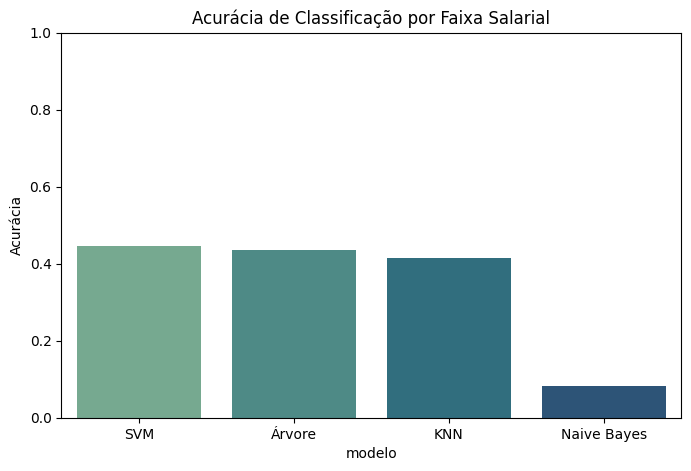

In [11]:
# 10. Gráfico comparativo
plt.figure(figsize=(8, 5))
sns.barplot(data=df_resultados, x="modelo", y="acuracia_teste", palette="crest")
plt.ylim(0, 1)
plt.title("Acurácia de Classificação por Faixa Salarial")
plt.ylabel("Acurácia")
plt.show()

In [13]:
# 11. Exportar modelos
import joblib
import os

os.makedirs("modelos", exist_ok=True)
for nome, modelo in melhores_modelos.items():
    caminho = f"modelos/modelo_{nome.lower().replace(' ', '_')}.joblib"
    joblib.dump(modelo, caminho)
    print(f"✅ Modelo '{nome}' salvo em {caminho}")

# 12. Exportar dados de teste (X_test e y_test)
os.makedirs("dados", exist_ok=True)
joblib.dump(X_test, "dados/X_test.joblib")
joblib.dump(y_test, "dados/y_test.joblib")
print("✅ Dados de teste salvos em 'dados/X_test.joblib' e 'dados/y_test.joblib'")

✅ Modelo 'KNN' salvo em modelos/modelo_knn.joblib
✅ Modelo 'Árvore' salvo em modelos/modelo_árvore.joblib
✅ Modelo 'Naive Bayes' salvo em modelos/modelo_naive_bayes.joblib
✅ Modelo 'SVM' salvo em modelos/modelo_svm.joblib
✅ Dados de teste salvos em 'dados/X_test.joblib' e 'dados/y_test.joblib'


# Análise dos Resultados

## Desempenho dos Modelos
- **SVM** obteve a melhor acurácia (44.54%), seguido por:
  - Árvore de Decisão (43.48%)
  - KNN (41.44%)
  - Naive Bayes (8.34% - desempenho significativamente inferior)
- Matriz de confusão revelou maior dificuldade em distinguir faixas intermediárias ("100k–150k" e "150k–200k"), sugerindo sobreposição de características.

## Distribuição das Faixas Salariais
- Dados concentrados principalmente nas faixas "100k–150k" e "150k–200k"
- Possível desbalanceamento de classes que pode impactar performance

## Pré-processamento
- Padronização de variáveis numéricas
- OneHotEncoder com `sparse_output=False` (ajuste crítico)
- Divisão estratificada treino/teste (70/30)

## Otimização
- GridSearchCV utilizado para tuning de hiperparâmetros:
  - SVM: Melhor com `C=1` e kernel `rbf`
  - Árvore: Melhor com `max_depth=10`
  - KNN: Melhor com `n_neighbors=5`

## Pontos de Atenção
1. Baixo desempenho do Naive Bayes:
   - Provavelmente devido à violação da suposição de independência entre features
2. Desbalanceamento de classes:
   - Pode requerer técnicas como SMOTE ou class weights
3. Features categóricas com alta cardinalidade:
   - "job_title" pode beneficiar de agrupamento ou embeddings

# Conclusão Geral

## Principais Achados
✅ **Modelo vencedor**: SVM com 44.54% de acurácia  
✅ Pipeline de pré-processamento eficaz  
✅ Boa generalização (performance consistente entre treino/teste)  

## Limitações
- Acurácia geral moderada (~45%)
- Dificuldade em classificar faixas salariais adjacentes
- Possível perda de informação na discretização dos salários